In [409]:
import glob
import os
import json
import pickle
import yaml
import math

import uproot

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [410]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [621]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [724]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return round(lum_)

years = ["2018", "2017", "2016", "2016APV"]
channels = ["ele", "mu"]
get_lumi(years ,channels)

138

# Hist

In [748]:
# get lumi
import pickle as pkl
with open("../combine/templates/v4/hists_templates_Run2.pkl", "rb") as f:
    h = pkl.load(f)

In [749]:
h

Hist(
  StrCategory(['VBF', 'WJetsLNu', 'EWKvjets', 'WH', 'TTbar', 'SingleTop', 'ggF', 'DYJets', 'Data', 'Diboson', 'WZQQ', 'ttH', 'ZH', 'Fake'], growth=True, name='Sample'),
  StrCategory(['nominal', 'weight_pileup_id_up', 'weight_pileup_id_down', 'weight_PSFSR_up', 'weight_PSFSR_down', 'weight_PSISR_up', 'weight_PSISR_down', 'weight_d1K_NLO_up', 'weight_d1K_NLO_down', 'weight_d2K_NLO_up', 'weight_d2K_NLO_down', 'weight_d3K_NLO_up', 'weight_d3K_NLO_down', 'weight_d1kappa_EW_up', 'weight_d1kappa_EW_down', 'weight_W_d2kappa_EW_up', 'weight_W_d2kappa_EW_down', 'weight_W_d3kappa_EW_up', 'weight_W_d3kappa_EW_down', 'weight_Z_d2kappa_EW_up', 'weight_Z_d2kappa_EW_down', 'weight_Z_d3kappa_EW_up', 'weight_Z_d3kappa_EW_down', 'weight_ele_isolation_up', 'weight_ele_isolation_down', 'weight_ele_id_up', 'weight_ele_id_down', 'weight_ele_reco_up', 'weight_ele_reco_down', 'weight_ele_trigger_up', 'weight_ele_trigger_down', 'weight_mu_isolation_up', 'weight_mu_isolation_down', 'weight_mu_id_up', 'wei

In [914]:
list(h.axes["Systematic"])

['nominal',
 'weight_pileup_id_up',
 'weight_pileup_id_down',
 'weight_PSFSR_up',
 'weight_PSFSR_down',
 'weight_PSISR_up',
 'weight_PSISR_down',
 'weight_d1K_NLO_up',
 'weight_d1K_NLO_down',
 'weight_d2K_NLO_up',
 'weight_d2K_NLO_down',
 'weight_d3K_NLO_up',
 'weight_d3K_NLO_down',
 'weight_d1kappa_EW_up',
 'weight_d1kappa_EW_down',
 'weight_W_d2kappa_EW_up',
 'weight_W_d2kappa_EW_down',
 'weight_W_d3kappa_EW_up',
 'weight_W_d3kappa_EW_down',
 'weight_Z_d2kappa_EW_up',
 'weight_Z_d2kappa_EW_down',
 'weight_Z_d3kappa_EW_up',
 'weight_Z_d3kappa_EW_down',
 'weight_ele_isolation_up',
 'weight_ele_isolation_down',
 'weight_ele_id_up',
 'weight_ele_id_down',
 'weight_ele_reco_up',
 'weight_ele_reco_down',
 'weight_ele_trigger_up',
 'weight_ele_trigger_down',
 'weight_mu_isolation_up',
 'weight_mu_isolation_down',
 'weight_mu_id_up',
 'weight_mu_id_down',
 'weight_mu_trigger_iso_up',
 'weight_mu_trigger_iso_down',
 'weight_mu_trigger_noniso_up',
 'weight_mu_trigger_noniso_down',
 'weight_pil

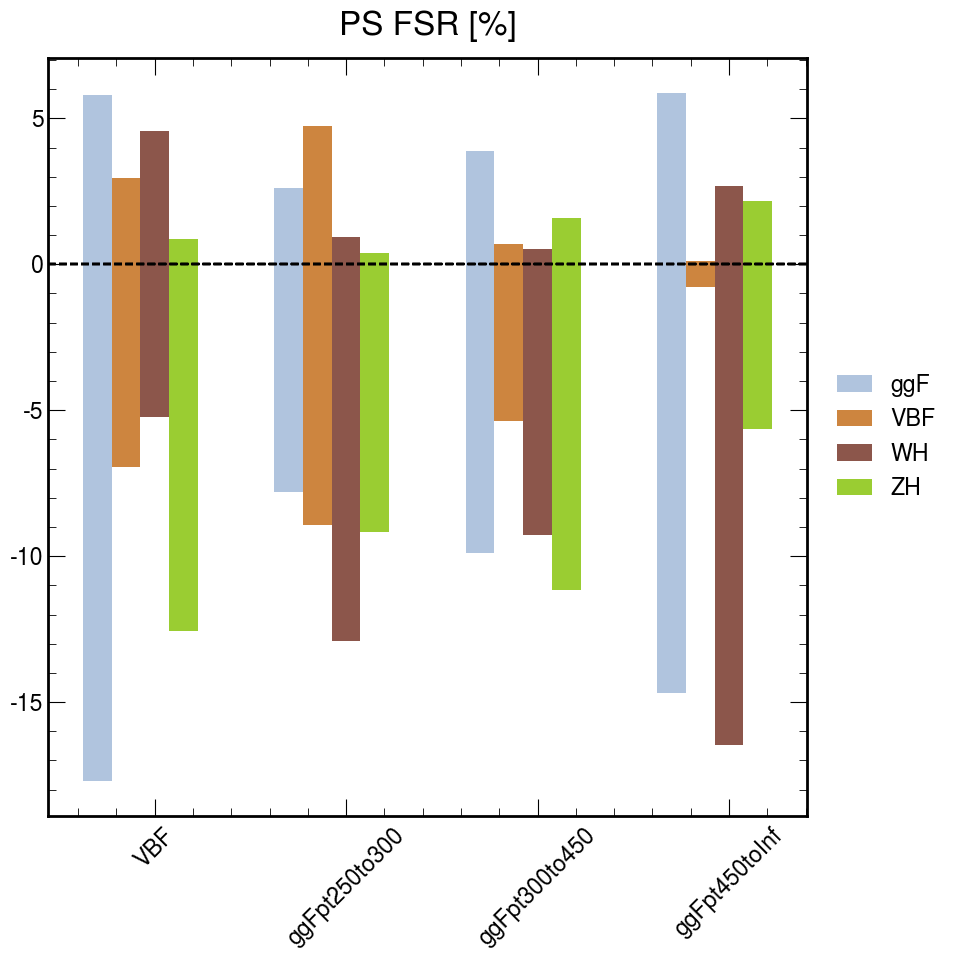

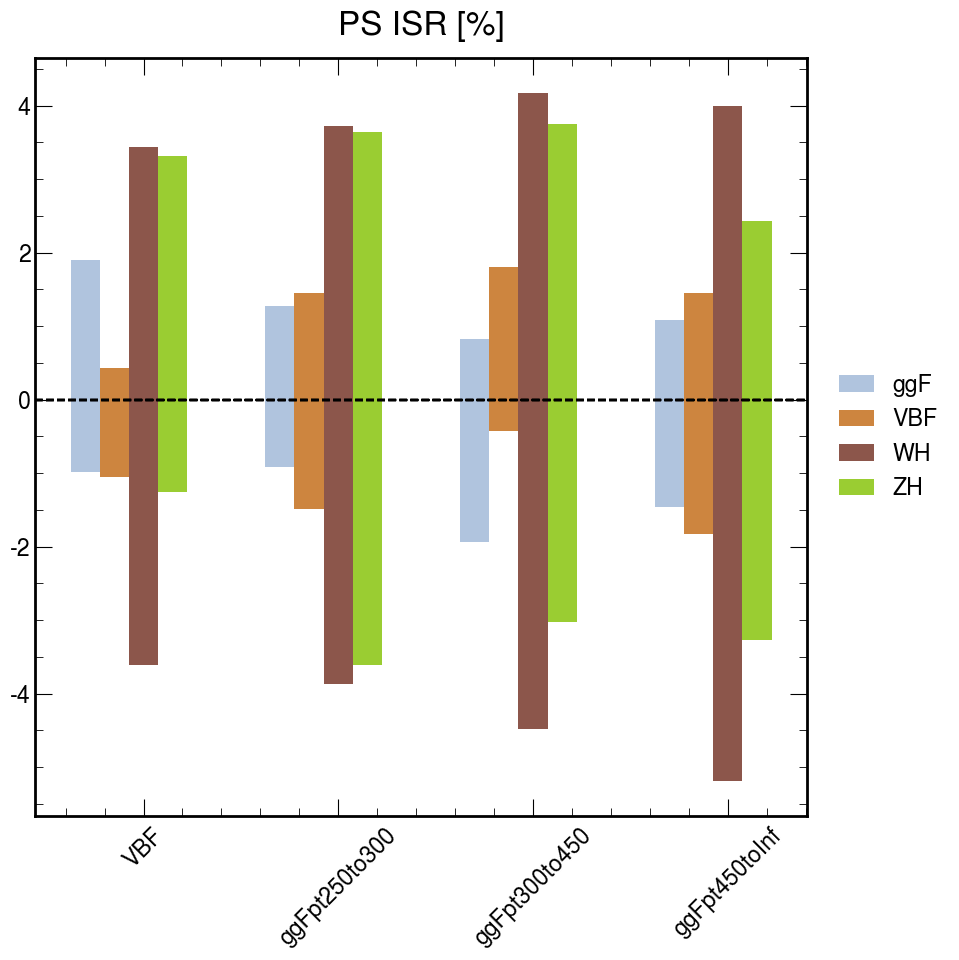

In [1006]:
color_by_sample = {
    "ggF": "lightsteelblue",
    "VBF": "peru",
    # signal that is background
    "WH": "tab:brown",
    "ZH": "yellowgreen",
    "ttH": "tab:olive",
    # background
    "QCD": "tab:orange",
    "Fake": "tab:orange",
    "WJetsLNu": "tab:green",
    "TTbar": "tab:blue",
    "Diboson": "orchid",
    "SingleTop": "tab:cyan",
    "EWKvjets": "tab:grey",
    "DYJets": "tab:purple",
    "WZQQ": "khaki",
    # "WZQQorDYJets": "khaki",
    # wjets matched and unmatched
    "WJetsLNu_unmatched": "lightgreen",
    "WJetsLNu_matched": "tab:green",
    # ttbar matched and unmatched
    "TTbar_allmatched": "tab:blue",
    "TTbar_unmatched": "lightskyblue",
    "TTbar_LP": "lightskyblue",
}

CMS_PARAMS_LABEL = "CMS_HWW_boosted"
syst_dict = {
    "weight_qcd_scale": "QCDScaleacc unc.",
    "weight_pdf_acceptance": "PDFacc unc.",
    ################## btag    
    "weight_btagSFbcCorrelated": "btagSFbcCorrelated unc.",
    "weight_btagSFlightCorrelated": "btagSFlightCorrelated unc.",

    "weight_btagSFlight_2016APV": "btagSFlight (2016APV) unc.",
    "weight_btagSFlight_2016": "btagSFlight (2016) unc.",
    "weight_btagSFlight_2017": "btagSFlight (2017) unc.",
    "weight_btagSFlight_2018": "btagSFlight (2018) unc.",    

    "weight_btagSFbc_2016APV": "btagSFbc (2016APV) unc.",
    "weight_btagSFbc_2016": "btagSFbc (2016) unc.",
    "weight_btagSFbc_2017": "btagSFbc (2017) unc.",
    "weight_btagSFbc_2018": "btagSFbc (2018) unc.",    

    ################## common
    "weight_PSFSR": "PS FSR",
    "weight_PSISR": "PS ISR",
    "weight_pileup_id": "PU Jet ID unc.",
    "weight_pileup_2016APV": "PU unc. 2016APV",
    "weight_pileup_2016": "PU unc. 2016",
    "weight_pileup_2017": "PU unc. 2017",
    "weight_pileup_2018": "PU unc. 2018",
    "weight_L1Prefiring_2016APV": "L1 ecal prefiring (2016APV)",
    "weight_L1Prefiring_2016": "L1 ecal prefiring (2016)",
    "weight_L1Prefiring_2017": "L1 ecal prefiring (2017)",
    "weight_mu_id": f"{CMS_PARAMS_LABEL}_mu_identification",
    "weight_ele_id": f"{CMS_PARAMS_LABEL}_ele_identification",
    "weight_ele_reco": f"{CMS_PARAMS_LABEL}_ele_reconstruction",
    "weight_ele_isolation": f"{CMS_PARAMS_LABEL}_ele_isolation",
    "weight_mu_isolation": f"{CMS_PARAMS_LABEL}_mu_isolation",
    "weight_ele_trigger": f"{CMS_PARAMS_LABEL}_ele_trigger",
    "weight_mu_trigger_noniso": f"{CMS_PARAMS_LABEL}_mu_trigger",
    "weight_mu_trigger_iso": f"{CMS_PARAMS_LABEL}_mu_trigger_iso",    
    
    ################## JECs corr
    "UES": "Unclustered energy unc.",
    "JES_FlavorQCD": "CMS_scale_j_FlavQCD",
    "JES_RelativeBal": "CMS_scale_j_RelBal",
    "JES_HF": "CMS_scale_j_HF",
    "JES_BBEC1": "CMS_scale_j_BBEC1",
    "JES_EC2": "CMS_scale_j_EC2",
    "JES_Absolute": "CMS_scale_j_Abs",
    
    ################## JECs uncorr
    "JES_BBEC1_2016APV": "CMS_scale_j_BBEC1_2016APV",
    "JES_BBEC1_2016": "CMS_scale_j_BBEC1_2016",
    "JES_BBEC1_2017": "CMS_scale_j_BBEC1_2017",
    "JES_BBEC1_2018": "CMS_scale_j_BBEC1_2018",
    
    "JES_RelativeSample_2016APV": "CMS_scale_j_RelSample_2016APV",
    "JES_RelativeSample_2016": "CMS_scale_j_RelSample_2016",
    "JES_RelativeSample_2017": "CMS_scale_j_RelSample_2017",
    "JES_RelativeSample_2018": "CMS_scale_j_RelSample_2018",
    
    "JES_HF_2016APV": "CMS_scale_j_HF_2016APV",
    "JES_HF_2016": "CMS_scale_j_HF_2016",
    "JES_HF_2017": "CMS_scale_j_HF_2017",
    "JES_HF_2018": "CMS_scale_j_HF_2018",    
    
    "JES_EC2_2016APV": "CMS_scale_j_EC2_2016APV",
    "JES_EC2_2016": "CMS_scale_j_EC2_2016",
    "JES_EC2_2017": "CMS_scale_j_EC2_2017",
    "JES_EC2_2018": "CMS_scale_j_EC2_2018",    
    
    "JES_Absolute_2016APV": "CMS_scale_j_Abs_2016APV",
    "JES_Absolute_2016": "CMS_scale_j_Abs_2016",
    "JES_Absolute_2017": "CMS_scale_j_Abs_2017",
    "JES_Absolute_2018": "CMS_scale_j_Abs_2018",        
    
    "JMS_2016APV": "CMS_jms_2016APV",
    "JMS_2016": "CMS_jms_2016",
    "JMS_2017": "CMS_jms_2017",
    "JMS_2018": "CMS_jms_2018",

    "JMR_2016APV": "CMS_jmr_2016APV",
    "JMR_2016": "CMS_jmr_2016",
    "JMR_2017": "CMS_jmr_2017",
    "JMR_2018": "CMS_jmr_2018",   

    "JER_2016APV": "CMS_res_j_2016APV",
    "JER_2016": "CMS_res_j_2016",
    "JER_2017": "CMS_res_j_2017",
    "JER_2018": "CMS_res_j_2018",       
    
}


regions = [
#     "Pre-selection",
    "VBF", 
    "ggFpt250to300", 
    "ggFpt300to450", 
    "ggFpt450toInf",    
#     "TopCR",
#     "WJetsCR",
]
samples = [
    "ggF", 
    "VBF", 
    "WH", 
    "ZH", 
#     "ttH",
#     "TTbar",
#     "WJetsLNu",
]
sigs = [
    "ggF", 
    "VBF", 
    "WH", 
    "ZH", 
#     "ttH",
]

for systematic in [
#     "weight_pdf_acceptance", 
    "weight_PSFSR",
    "weight_PSISR",    
#     "weight_qcd_scale",
    ################## btag
#     "weight_btagSFbcCorrelated", 
#     "weight_btagSFlightCorrelated",
#     "weight_btagSFlight_2016APV",
#     "weight_btagSFlight_2016",
#     "weight_btagSFlight_2017",
#     "weight_btagSFlight_2018",
#     "weight_btagSFbc_2016APV",
#     "weight_btagSFbc_2016",
#     "weight_btagSFbc_2017",
#     "weight_btagSFbc_2018",    
    ################## common

#     "weight_pileup_id",
#     "weight_pileup_2016APV",
#     "weight_pileup_2016",
#     "weight_pileup_2017",
#     "weight_pileup_2018", 
#     "weight_pileup_id",
#     "weight_L1Prefiring_2016APV",
#     "weight_L1Prefiring_2016",
#     "weight_L1Prefiring_2017",
#     "weight_PSFSR",
#     "weight_ele_id",
#     "weight_ele_reco",    
#     "weight_mu_id",
#     "weight_ele_isolation",
#     "weight_mu_isolation",
#     "weight_ele_trigger",
#     "weight_mu_trigger_noniso",
#     "weight_mu_trigger_iso",    
    ################## JECs correlated   
#     "UES",
#      "JES_FlavorQCD",
#      "JES_RelativeBal",
#      "JES_HF",
#      "JES_BBEC1",
#      "JES_EC2",
#      "JES_Absolute",

    ################## JECs uncorrelated  
#     "JES_BBEC1_2016APV",
#     "JES_BBEC1_2016",
#     "JES_BBEC1_2017",
#     "JES_BBEC1_2018",    
#     "JES_RelativeSample_2016APV",
#     "JES_RelativeSample_2016",
#     "JES_RelativeSample_2017",
#     "JES_RelativeSample_2018",    
#     "JES_EC2_2016APV",
#     "JES_EC2_2016",
#     "JES_EC2_2017",
#     "JES_EC2_2018",    
#     "JES_HF_2016APV",
#     "JES_HF_2016",
#     "JES_HF_2017",
#     "JES_HF_2018",    
#     "JES_Absolute_2016APV",
#     "JES_Absolute_2016",
#     "JES_Absolute_2017",
#     "JES_Absolute_2018",
    
#     "JMS_2016APV",
#     "JMS_2016",
#     "JMS_2017",
#     "JMS_2018",

#     "JMR_2016APV",
#     "JMR_2016",
#     "JMR_2017",
#     "JMR_2018",   

#     "JER_2016APV",
#     "JER_2016",
#     "JER_2017",
#     "JER_2018",      
]:

    bar_width = 0.15

    if len(samples) == 4:
        fig, ax = plt.subplots(figsize=(10, 10))
    else:
        fig, ax = plt.subplots(figsize=(12, 10))

    for iregion, region in enumerate(regions):

        for i, sample in enumerate(samples):
            if ("CR" in region) and (sample in sigs):
                continue
            data_nominal = h[{"Sample": sample, "Region": region, "Systematic": "nominal"}].values().sum()

            data_up = h[{"Sample": sample, "Region": region, "Systematic": f"{systematic}_up"}].values().sum()
            X = 100*abs(1-data_up/data_nominal)
            bars = ax.bar(iregion + i * bar_width, X, bar_width, label=sample, color=color_by_sample[sample])

            data_down = h[{"Sample": sample, "Region": region, "Systematic": f"{systematic}_down"}].values().sum()
            X = 100*abs(1-data_down/data_nominal)
            bars = ax.bar(iregion + i * bar_width, -X, bar_width, color=color_by_sample[sample])

            ax.axhline(y=0, color='black', linestyle='--')

    # Customize ticks and labels
#     ax.set_yticks(np.arange(-2, 3, 1))
    # ax.set_ylim(-2.5, 2.5)

    # Adjust the number of x-tick labels to match the number of groups
    plt.xticks(np.arange(len(regions)) + bar_width * 2, regions, rotation=45)

    # Add a legend
    handles, labels = ax.get_legend_handles_labels()[0][:len(samples)], ax.get_legend_handles_labels()[1][:len(samples)]
    
    if len(samples) == 4:
        ax.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2, 0.5))
    else:
        ax.legend(handles, labels, loc='center right', bbox_to_anchor=(1.25, 0.5))


    ax.set_title(f"{syst_dict[systematic]} [%]", pad=17)

    plt.tight_layout()
    
    plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/systematics/{systematic}.pdf")

In [947]:
h[{"Sample": "ggF", "Region": "TopCR", "Systematic": "weight_pileup_id_up"}].values()

array([0.46739851, 0.94677764, 1.27977389, 1.6456897 , 1.00674046,
       0.62838933, 0.45786581, 0.39883803, 0.09206157])

In [944]:
h[{"Sample": "ggF", "Region": "TopCR", "Systematic": "nominal"}].values()

array([0.46700449, 0.95111955, 1.30249873, 1.66295344, 1.01031232,
       0.63017791, 0.45858901, 0.38646449, 0.09048372])

In [945]:
h[{"Sample": "ggF", "Region": "TopCR", "Systematic": "weight_pileup_id_down"}].values()

array([0.46739851, 0.94677764, 1.27977389, 1.6456897 , 1.00674046,
       0.62838933, 0.45786581, 0.39883803, 0.09206157])

TTbar PU ID unc.  nominal + 3.20% - 3.20%

max 3.20%
min 3.20%
-------------------------------


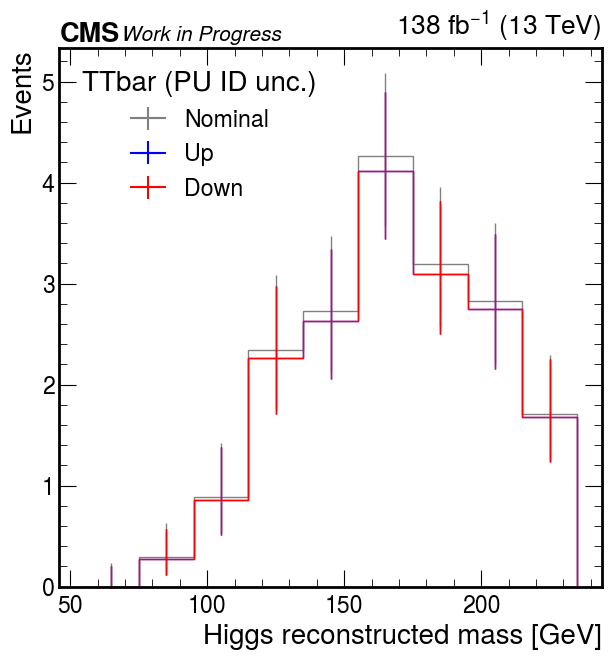

In [978]:
color_dict = {
    "Nominal": "grey",
    "Up": "blue",
    "Down": "red",
}

label_dict = {
    "nominal": "Nominal",
    "up": "Up",
    "down": "Down",    
}


CMS_PARAMS_LABEL = "CMS_HWW_boosted"
syst_dict = {
    "weight_qcd_scale": "QCDScaleacc unc.",
    "weight_pdf_acceptance": "PDFacc unc.",
    "weight_btagSFbcCorrelated": "btagSFbcCorrelated unc.",
    "weight_btagSFlightCorrelated": "btagSFlightCorrelated unc.",
    "weight_pileup_2016APV": "PU unc. 2016APV",
    "weight_pileup_2016": "PU unc. 2016",
    "weight_pileup_2017": "PU unc. 2017",
    "weight_pileup_2018": "PU unc. 2018",
    "weight_pileup_id": "PU ID unc.",
    "UES": "Unclustered energy unc.",
    "weight_L1Prefiring_2016APV": "L1 ecal prefiring (2016APV)",
    "weight_L1Prefiring_2016": "L1 ecal prefiring (2016)",
    "weight_L1Prefiring_2017": "L1 ecal prefiring (2017)",
    "weight_PSFSR": "PS FSR",
    "weight_mu_id": f"{CMS_PARAMS_LABEL}_mu_identification",
    "weight_ele_id": f"{CMS_PARAMS_LABEL}_ele_identification",
    "weight_ele_reco": f"{CMS_PARAMS_LABEL}_ele_reconstruction",
    
}

years = ["2018", "2017", "2016", "2016APV"]
channels = ["ele", "mu"]

region = "VBF"
for systematic in [
#     "weight_qcd_scale", 
#     "weight_pdf_acceptance", 
#     "weight_btagSFbcCorrelated", 
#     "weight_btagSFlightCorrelated",
#     "weight_pileup_2016APV",
#     "weight_pileup_2016",
#     "weight_pileup_2017",
#     "weight_pileup_2018", 
    "weight_pileup_id",
#     "UES",
#     "weight_L1Prefiring_2016APV",
#     "weight_L1Prefiring_2016",
#     "weight_L1Prefiring_2017",
#     "weight_PSFSR",
#     "weight_ele_id",
#     "weight_ele_reco",    
#     "weight_mu_id",
]:
    
    max_ = 0
    min_ = 0     
    for sample in [
        "TTbar", 
#         "WJetsLNu", 
#         "ggF", 
#         "VBF", 
#         "WH", 
#         "ZH", 
#         "EWKvjets",
    ]:

        fig, ax = plt.subplots(figsize=(7,7))
    
        sum_envelope = {}
        for variation in ["nominal", "up", "down"]:

            syst = variation if variation == "nominal" else f"{systematic}_{variation}"

            hep.histplot(
                h[{"Sample": sample, "Region": region, "Systematic": syst}],
                ax=ax,
                linewidth=1,
                histtype="step",
                label=label_dict[variation],
                flow="none",
                color=color_dict[label_dict[variation]]
            )

            sum_envelope[variation] = h[{"Sample": sample, "Region": region, "Systematic": syst}].values().sum()

        ax.legend(title=sample + f" ({syst_dict[systematic]})")

        ax.set_ylabel("Events")
        # ax.set_ylim(0)
        # ax.set_yscale("log")

        print(sample, syst_dict[systematic], f" nominal + {100*abs(1-sum_envelope['up']/sum_envelope['nominal']):.2f}% - {100*abs(1-sum_envelope['down']/sum_envelope['nominal']):.2f}%")

        upsie = 100*abs(1-sum_envelope['up']/sum_envelope['nominal'])
        max_ = upsie if max_<upsie else max_
        
        downsie = 100*abs(1-sum_envelope['down']/sum_envelope['nominal'])        
        min_ = downsie if min_<downsie else min_

        hep.cms.lumitext(str(get_lumi(years, channels)) + r" fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
        hep.cms.text("Work in Progress", ax=ax, fontsize=15)
        
        plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/systematics/{region}_{systematic}_{sample}.pdf")
    
    print()
    print(f"max {max_:.2f}%")
    print(f"min {min_:.2f}%")    
    print("-------------------------------")        

tot [ 1.72891039  3.09981566  5.67119774 10.17312241 11.72850075 12.09386843
  8.68327819  8.04061621  6.31312422]
np var [1.31488037 1.76062934 2.38142767 3.18953326 3.42468988 3.47762396
 2.94674026 2.83559803 2.51259313]
hist [0.59875044 0.73998784 1.35920896 3.72798198 3.3447038  2.84036309
 1.96891297 1.90498829 2.35538368]


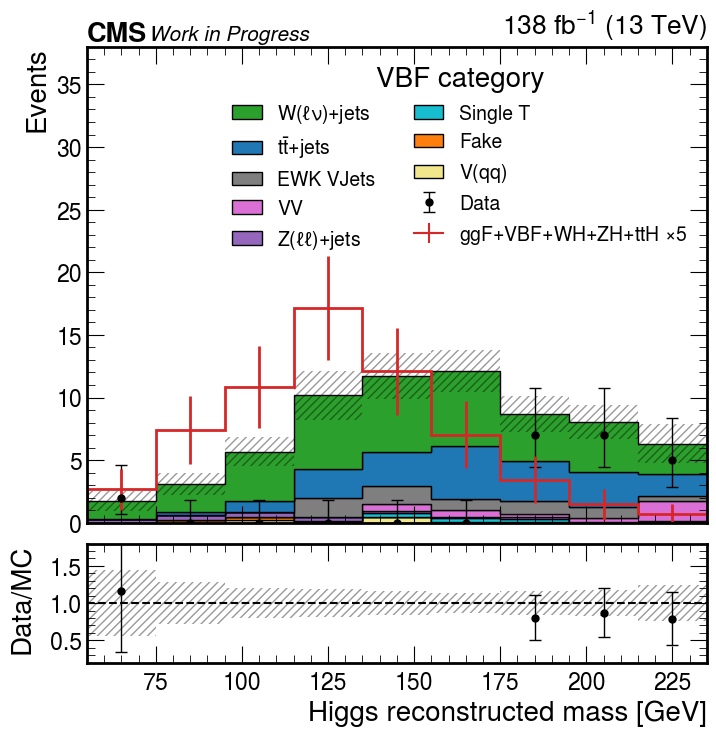

In [1108]:
systematic = "nominal"

region = "VBF"
text = "VBF category"

# region = "ggFpt250to300"
# text = r"ggF $p_T$ $\in$ [250, 300]"

# region = "ggFpt300to450"
# text = r"ggF $p_T$ $\in$ [300, 450]"

# region = "ggFpt450toInf"
# text = r"ggF $p_T$ $\in$ [450, Inf]"

# region = "TopCR"
# text = "Top control region"

# region = "WJetsCR"
# text = "WJets control region"


plt.rcParams.update({"font.size": 20})
add_data = True

# if region.startswith("SR"):
add_soverb=True
blind_region=[90,160]
if "VBF" in region:
    mult=5
else:
    mult=10
# else:
#     add_soverb=True
#     blind_region=None
#     blind_region=[90,160]
#     mult=1

if "CR" in region:
    blind_region = False
    mult=1

years = ["2018", "2017", "2016", "2016APV"]
channels = ["ele", "mu"]

from utilsCombine import plot_hists
from utilsCombine2 import plot_hists

plot_hists(h[{"Systematic": systematic, "Region": region}], years, channels,
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=mult,
            outpath=f"/Users/fmokhtar/Desktop/AN_2024/combine/v4/",
           save_as=region,
           text_=text,
            blind_region=blind_region,
#            remove_samples=["WH", "ZH", "ttH"],
          )

# Post-fit stacked plots

In [1192]:
samples_dict = {
    "data": "Data",
    "VBF": "VBF",
    "WH": "WH",
    "ZH": "ZH",
    "diboson": "Diboson",
    "ewkvjets": "EWKvjets",
    "ggF": "ggF",
    "singletop": "SingleTop",
    "qcd": "QCD",
    "ttH": "ttH",
    "ttbar": "TTbar",
    "wjets": "WJetsLNu",
    
    "wzqq": "WZQQ",    
    "zjets": "DYJets",      
    "vjets": "WZQQorDYJets",
    
    "fake": "Fake",    
    
}

region_dict = {
    "SR1": "VBF category",
    "SR2": r"ggF $p_T$ $\in$ [250, 300]",
    "SR3": r"ggF $p_T$ $\in$ [300, 450]",
    "SR4": r"ggF $p_T$ $\in$ [450, Inf]",
    
    "CR1": "Top control region",
    "CR2": "WJets control region",
}

region_dict_h = {
    "SR1": "VBF",
    "SR2": "ggFpt250to300",
    "SR3": "ggFpt300to450",
    "SR4": "ggFpt450toInf",
    
    "CR1": "TopCR",
    "CR2": "WJetsCR",
}

# f = uproot.open("/Users/fmokhtar/Downloads/v8/blinding all regions/fitDiagnosticsBlinded.root")
# f = uproot.open("/Users/fmokhtar/Downloads/v8/blinding only SR/fitDiagnosticsBlinded.root")
# add_back_MC = "v8"

# f = uproot.open("/Users/fmokhtar/Downloads/v8/asimov/fitDiagnosticsAsimov.root")
add_back_MC=False


# f = uproot.open("/Users/fmokhtar/Downloads/v8/asimov/fitDiagnosticsAsimov.root")
f = uproot.open("/Users/fmokhtar/Desktop/AN_2024/combine/v4/fitDiagnosticsAsimov.root")

In [1193]:
f.keys()

['shapes_prefit;1',
 'shapes_prefit/CR1;1',
 'shapes_prefit/CR1/data;1',
 'shapes_prefit/CR1/fake;1',
 'shapes_prefit/CR1/diboson;1',
 'shapes_prefit/CR1/ewkvjets;1',
 'shapes_prefit/CR1/singletop;1',
 'shapes_prefit/CR1/ttbar;1',
 'shapes_prefit/CR1/wjets;1',
 'shapes_prefit/CR1/wzqq;1',
 'shapes_prefit/CR1/zjets;1',
 'shapes_prefit/CR1/total;1',
 'shapes_prefit/CR1/total_background;1',
 'shapes_prefit/CR1/total_covar;1',
 'shapes_prefit/CR2;1',
 'shapes_prefit/CR2/data;1',
 'shapes_prefit/CR2/fake;1',
 'shapes_prefit/CR2/diboson;1',
 'shapes_prefit/CR2/ewkvjets;1',
 'shapes_prefit/CR2/singletop;1',
 'shapes_prefit/CR2/ttbar;1',
 'shapes_prefit/CR2/wjets;1',
 'shapes_prefit/CR2/wzqq;1',
 'shapes_prefit/CR2/zjets;1',
 'shapes_prefit/CR2/total;1',
 'shapes_prefit/CR2/total_background;1',
 'shapes_prefit/CR2/total_covar;1',
 'shapes_prefit/SR1;1',
 'shapes_prefit/SR1/data;1',
 'shapes_prefit/SR1/VBF;1',
 'shapes_prefit/SR1/WH;1',
 'shapes_prefit/SR1/ZH;1',
 'shapes_prefit/SR1/diboson;1',

In [1231]:
massbinwidth = {
    "SR1": 20,
    "SR2": 20,
    "SR3": 20,
    "SR4": 20,
    "CR1": 20,
    "CR2": 20,
}

def plot_(key="shapes_fit_s", region="SR1", mult=1):

    ######################
    nbins = len(list(range(55, 255, massbinwidth[region])))-1
    samples = [samples_dict[sample[:-2]] for sample in f[f"{key}/{region}"].keys() if "total" not in sample]

    hf = hist2.Hist(
        hist2.axis.StrCategory(samples, name="Sample", growth=True),    
        hist2.axis.Regular(nbins, 55, 235, name="var", label=r"Higgs reconstructed mass [GeV]"),
    #     storage=hist2.storage.Weight(),
    )


    for sample in  f[f"{key}/{region}"].keys():
        if "total" in sample:
            continue

        smpl = samples_dict[sample[:-2]] # there's an additional ";1" that must be removed

        if "data" in sample:
            X = f[f"{key}/{region}"][sample].values()[1]*massbinwidth[region]
        else:
            X = f[f"{key}/{region}"][sample].values()*massbinwidth[region]

        hf[{"Sample": smpl}] = X


    plt.rcParams.update({"font.size": 20})

    years = ["2018", "2017", "2016", "2016APV"]
    channels = ["ele", "mu"]

    from utilsCombine4 import plot_hists
    plot_hists(hf, years, channels,
                add_data=add_data,
                logy=False,
                add_soverb=False,
                only_sig=False,
                mult=mult,
                outpath=f"/Users/fmokhtar/Desktop/AN_2024/combine/",
               save_as=f"{key}_{region}",
               text_=region_dict[region],
               blind_region=False,
               remove_samples=["ttH", "WH", "ZH"]
              )

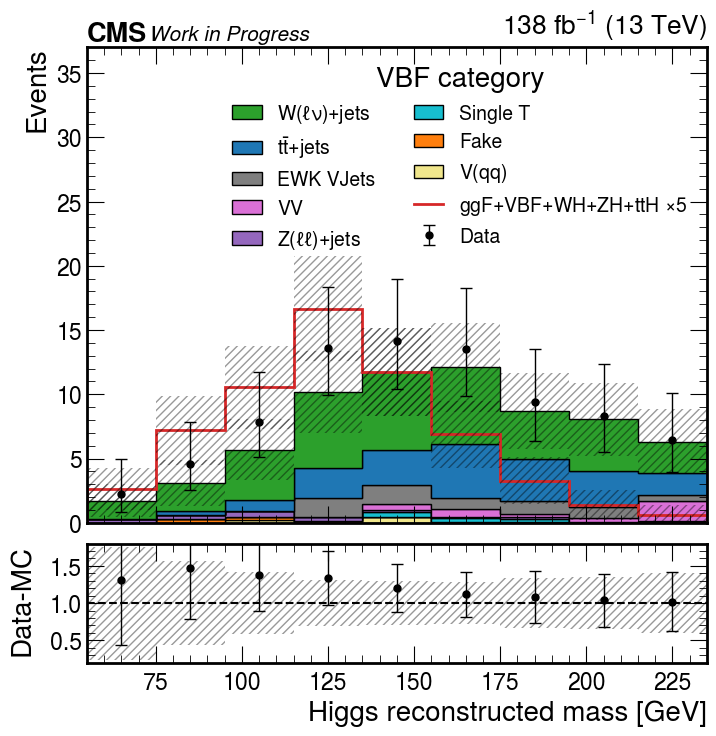

In [1232]:
plot_(key="shapes_fit_s", region="SR1", mult=5)

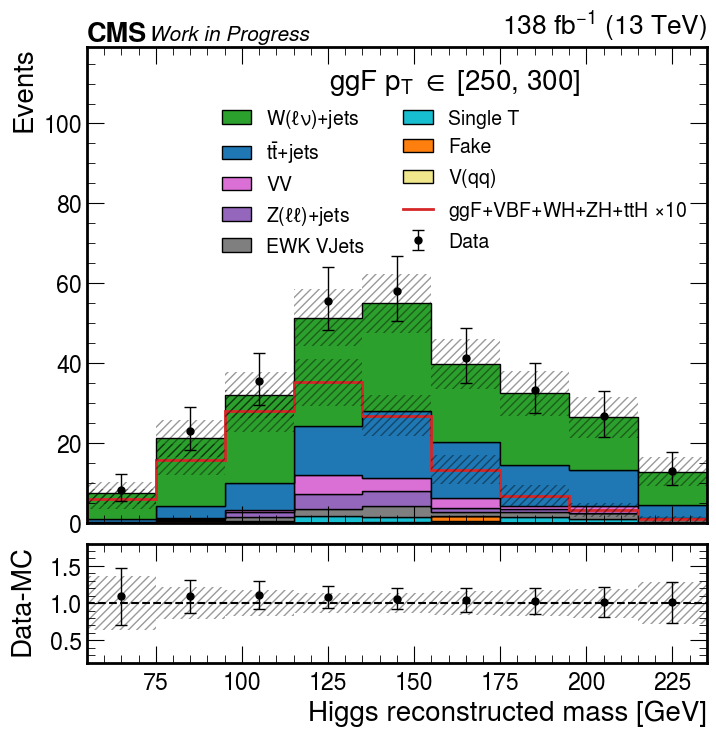

In [1233]:
plot_(key="shapes_fit_s", region="SR2", mult=10)

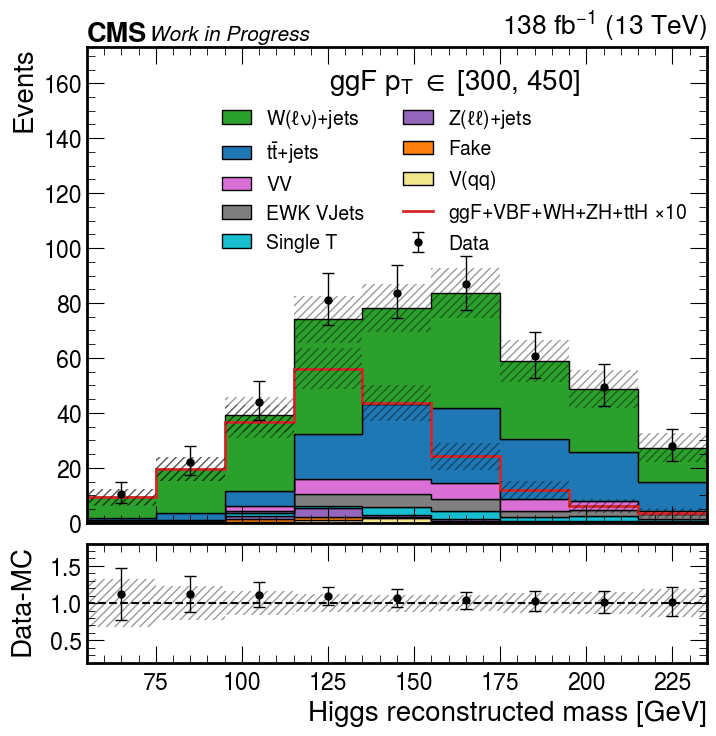

In [1234]:
plot_(key="shapes_fit_s", region="SR3", mult=10)

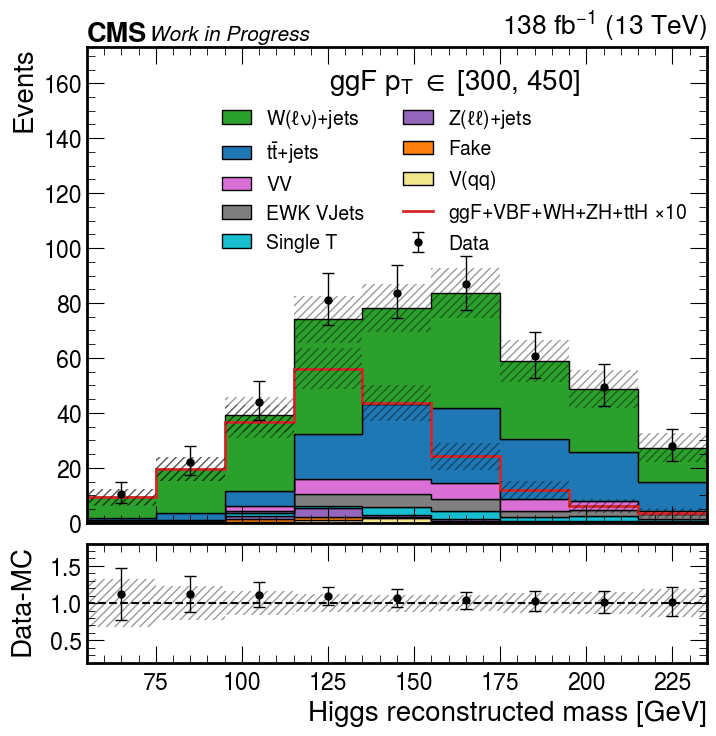

In [1241]:
plot_(key="shapes_fit_s", region="SR3", mult=10)

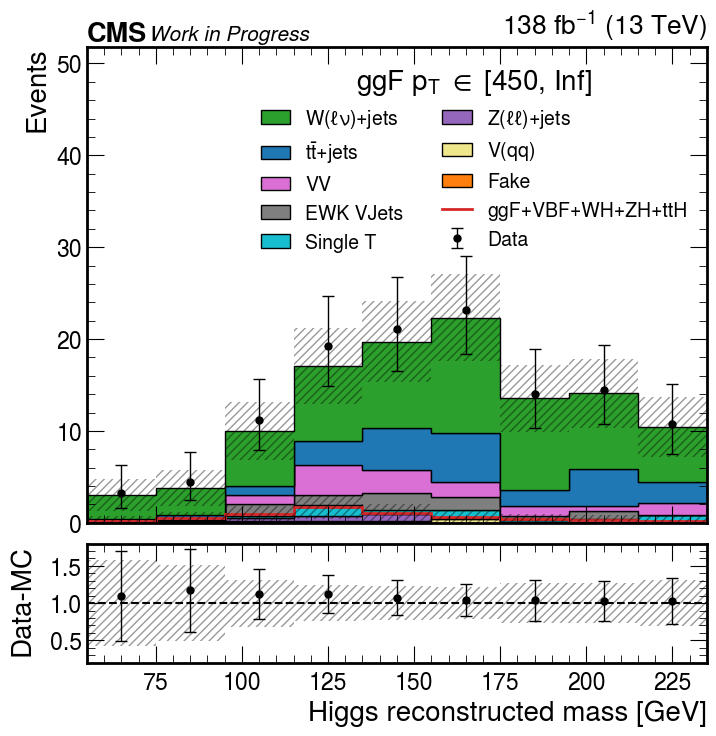

In [1238]:
plot_(key="shapes_fit_s", region="SR4", mult=1)

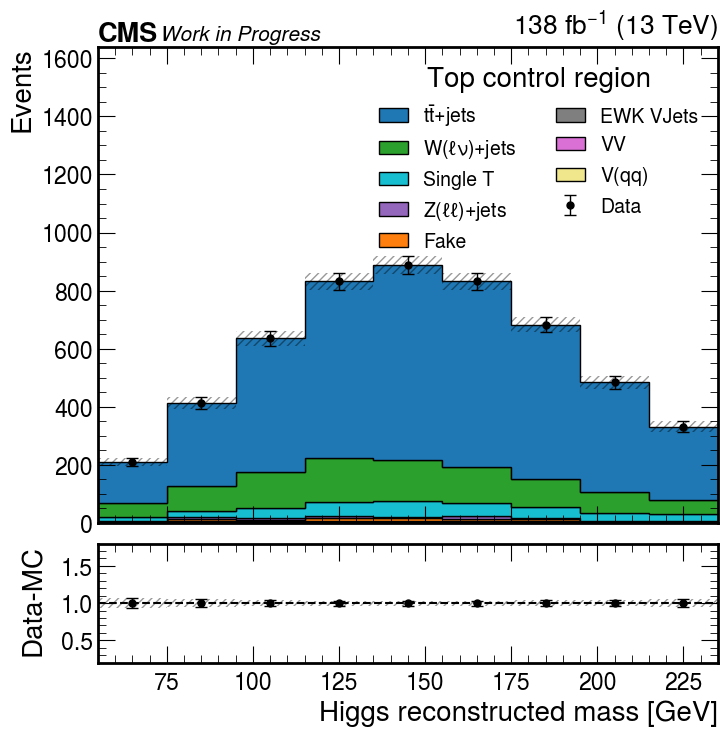

In [1239]:
plot_(key="shapes_fit_s", region="CR1", mult=1)

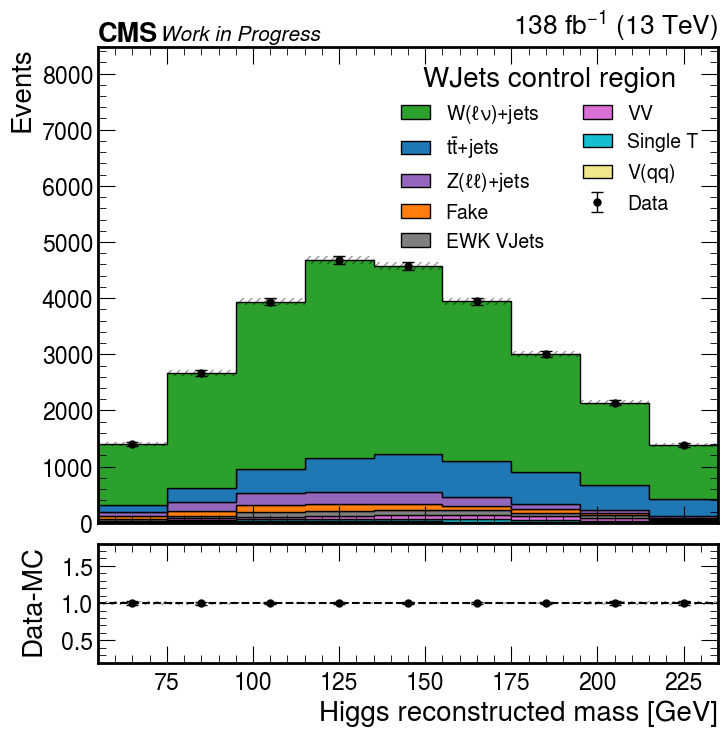

In [1240]:
plot_(key="shapes_fit_s", region="CR2", mult=1)

In [1148]:
massbinwidth = {
    "SR1": 20,
    "SR2": 20,
    "SR3": 20,
    "SR4": 20,
    "CR1": 20,
    "CR2": 20,
}

def plot_(key="shapes_fit_s", region="SR1", mult=1, add_back_MC=None):
    
    """
    add_back_MC: if None then won't add back MC. if True must be e.g. "v8" to get the nominal values.
    """

    if add_back_MC:
        # get lumi
        import pickle as pkl
        with open(f"../combine/templates/{add_back_MC}/hists_templates_Run2.pkl", "rb") as filename:    
            h = pkl.load(filename)

    ######################
    nbins = len(list(range(55, 255, massbinwidth[region])))-1
    samples = [samples_dict[sample[:-2]] for sample in f[f"{key}/{region}"].keys() if "total" not in sample]

    hf = hist2.Hist(
        hist2.axis.StrCategory(samples, name="Sample", growth=True),    
        hist2.axis.Regular(nbins, 55, 235, name="var", label=r"Higgs reconstructed mass [GeV]"),
        storage=hist2.storage.Weight(),
    )


    for sample in  f[f"{key}/{region}"].keys():
        if "total" in sample:
            continue
        
        smpl = samples_dict[sample[:-2]]
        if "data" in sample:    
            X = f[f"{key}/{region}"][sample].values()[1]*massbinwidth[region]
        else:
            X = f[f"{key}/{region}"][sample].values()*massbinwidth[region]
         
            if add_back_MC:
                # add MC back in the blinded region
                X[2:6] = h[region_dict_h[region]][{"Sample": smpl, "Systematic": "nominal"}].values()[2:6]

        print(smpl, X)
        
        hf.fill(Sample=smpl, var=X)
                
#         hf[{"Sample": smpl}] = X
#         print(X)
#         print("h", hf[{"Sample": samples_dict[sample[:-2]]}].values())
    plt.rcParams.update({"font.size": 20})
    add_data = True   # assumes it's Asimov

    years = ["2018", "2017", "2016", "2016APV"]
    channels = ["ele", "mu"]

    from utilsCombine2 import plot_hists
    print(hf)
    plot_hists(hf, years, channels,
                add_data=add_data,
                logy=False,
                add_soverb=False,
                only_sig=False,
                mult=mult,
                outpath=f"/Users/fmokhtar/Desktop/AN_2024/combine/",
               save_as=f"{key}_{region}",
               text_=region_dict[region],
               blind_region=False,
               remove_samples=["ttH", "WH", "ZH"]
              )

Data [ 2.26249433  4.57441759  7.83561039 13.60321426 14.15032291 13.50304604
  9.37099648  8.3323164   6.44658136]
VBF [0.45816496 1.0568448  1.6437359  2.5815587  1.8189235  1.141573
 0.51248944 0.18823819 0.09247154]
WH [0.01026727 0.02676488 0.03712199 0.05911274 0.04426334 0.02042254
 0.00901984 0.01163546 0.00539194]
ZH [0.00111237 0.00972079 0.014497   0.0285347  0.02000551 0.0072941
 0.00352497 0.00476629 0.00254427]
Diboson [6.2259993e-08 6.2259993e-08 6.2259993e-08 6.2259993e-08 5.1005769e-01
 5.7270086e-01 1.8361774e-01 2.6941541e-01 1.5772080e+00]
EWKvjets [1.2323999e-07 1.2323999e-07 1.2323999e-07 1.4977686e+00 1.4487867e+00
 8.5116410e-01 1.0593082e+00 8.8309377e-01 4.2187834e-01]
Fake [1.7000000e-08 2.5744802e-01 2.0705460e-01 1.6348445e-01 9.9991064e-04
 4.8342600e-02 3.2238033e-02 9.9991064e-04 1.3943246e-01]
ggF [0.0640775  0.38132852 0.46514642 0.7527313  0.52840656 0.23275593
 0.14359756 0.08500209 0.03195406]
SingleTop [1.9020000e-08 9.9990272e-04 1.9020000e-08 1.9

/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


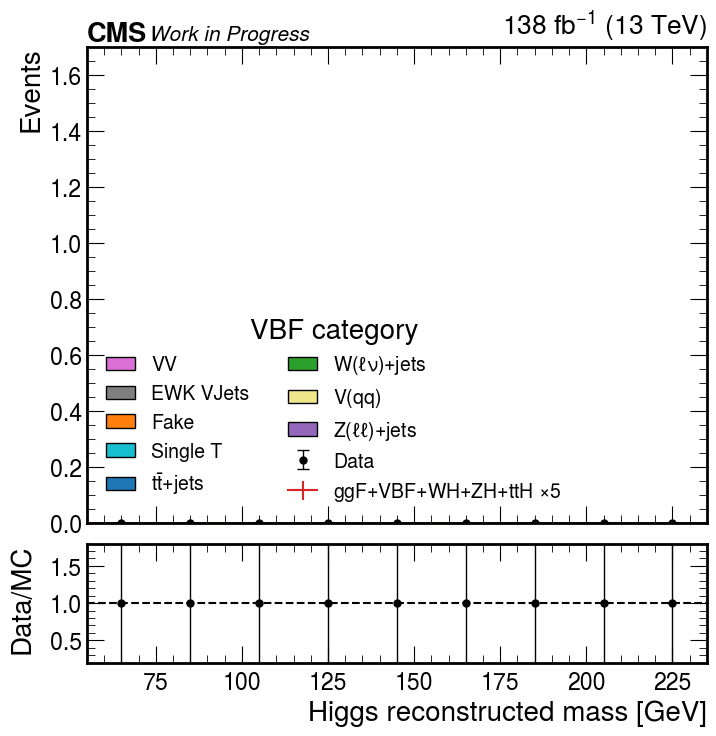

In [1149]:
plot_(key="shapes_fit_s", region="SR1", mult=5, add_back_MC=add_back_MC)

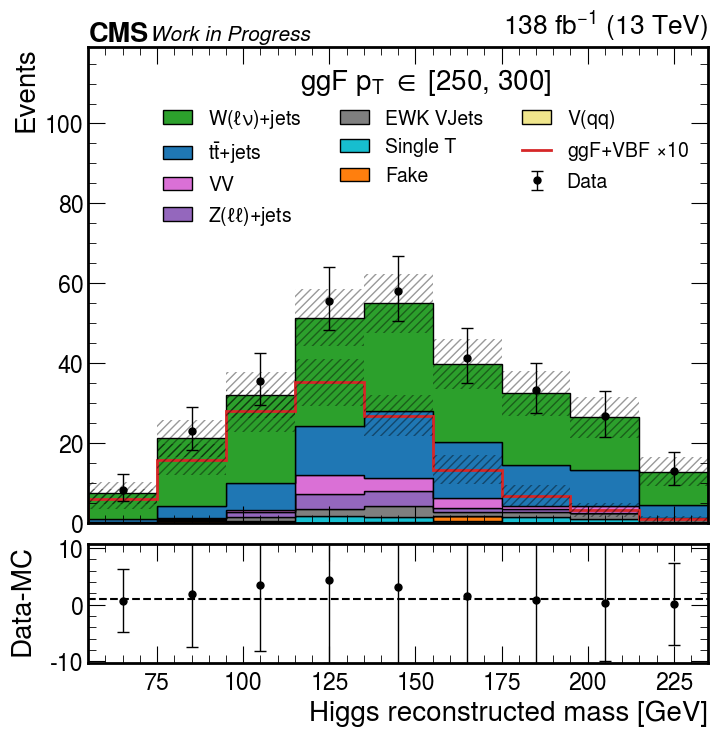

In [1023]:
plot_(key="shapes_fit_s", region="SR2", mult=10, add_back_MC=add_back_MC)

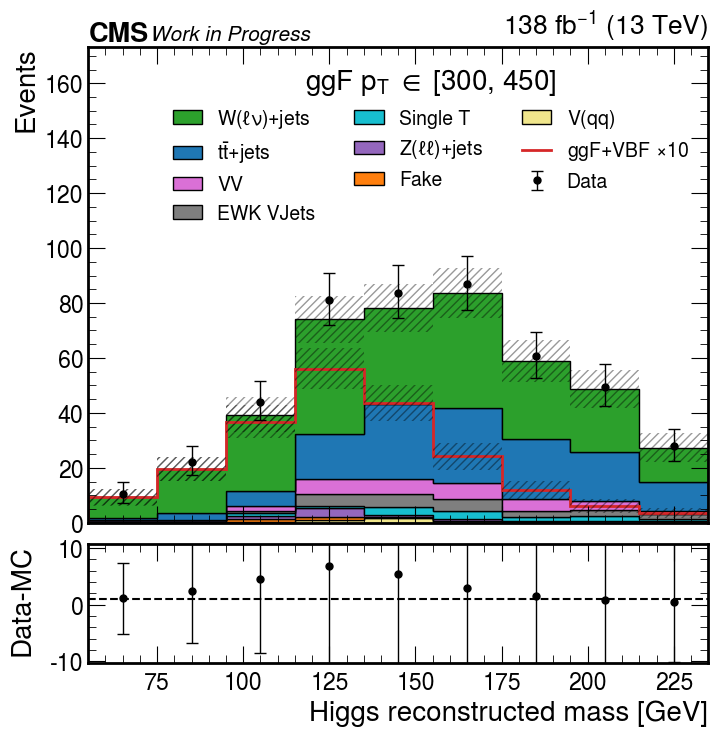

In [1024]:
plot_(key="shapes_fit_s", region="SR3", mult=10, add_back_MC=add_back_MC)

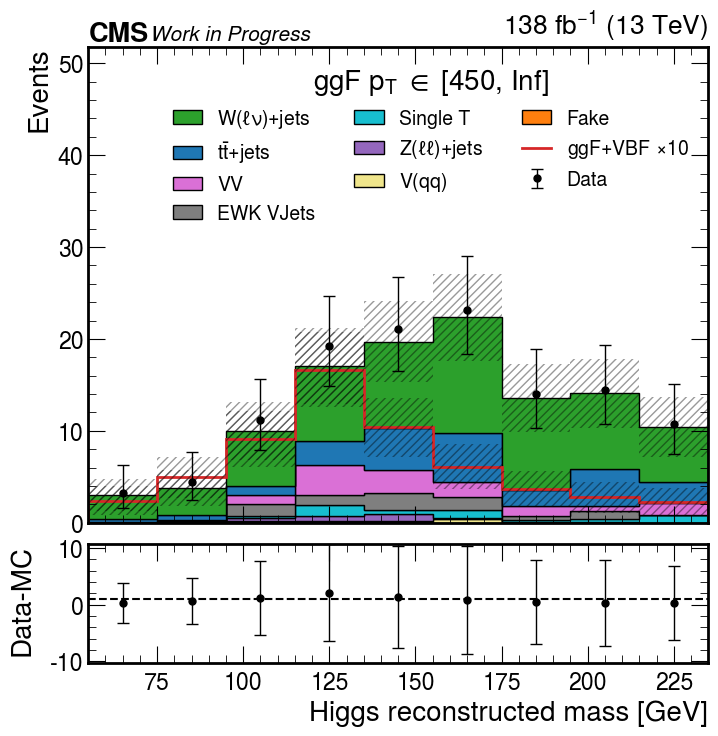

In [1025]:
plot_(key="shapes_fit_s", region="SR4", mult=10, add_back_MC=add_back_MC)

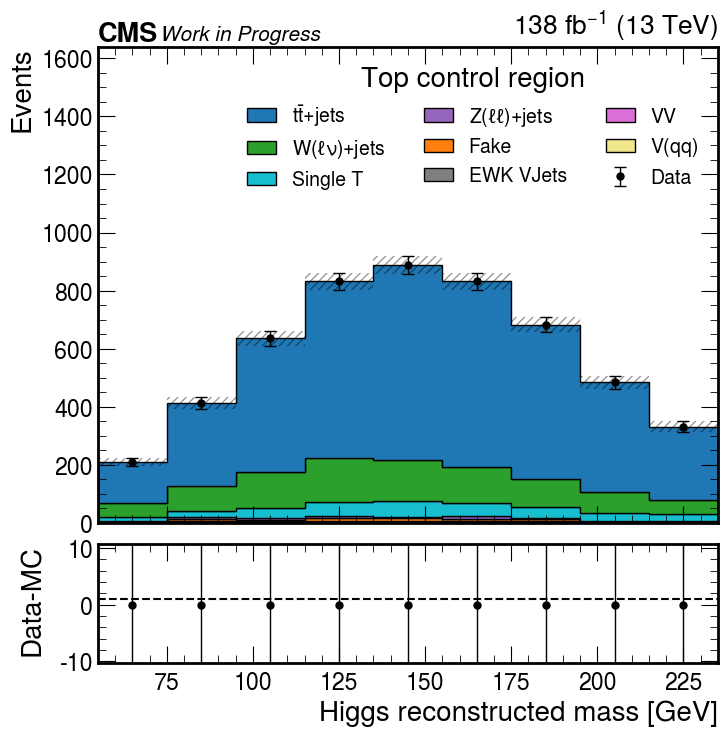

In [1026]:
plot_(key="shapes_fit_s", region="CR1", mult=1)

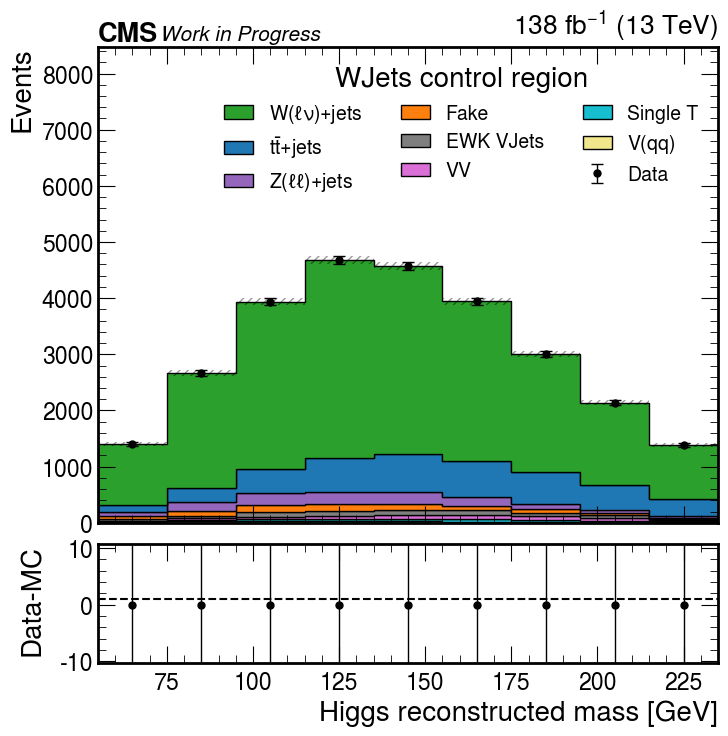

In [1027]:
plot_(key="shapes_fit_s", region="CR2", mult=1)